# Problem 1

In [18]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

## 1.1.1

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


Text(10, -2, 'The label is 5')

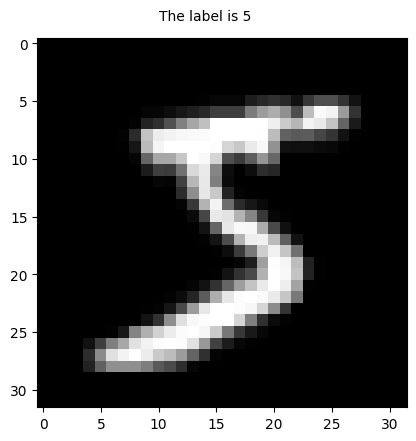

In [20]:
print(train_dataset[0][0])
plt.imshow(train_dataset[0][0].squeeze(), cmap='gray')
plt.text(10, -2, 'The label is ' + str(train_dataset[0][1]))

In [21]:
# hyper parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

## 1.1.2

In [22]:
# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle = False)

## 1.1.3

In [23]:

def train(train_loader, model, criterion, optimizer):
    '''
    Train one epoch.
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        #gradient to zero
        optimizer.zero_grad()
    
        # Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

## 1.1.4

In [24]:
def validate(valid_loader, model, criterion):
    '''
    Function for the validation step of the training loop.
    Returns the model and the loss on the test set.
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:

        # Forward pass and record loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        # Update running loss to calculate the average
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [25]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader,)
            train_accs.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader)
            valid_accs.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
    
    performance = {
        'train_losses':train_losses,
        'valid_losses': valid_losses,
        'train_acc': train_accs,
        'valid_acc':valid_accs
    }
    
    return model, optimizer, performance

## 1.1.5

In [26]:
def get_accuracy(model, data_loader):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model = model.eval()
        for X, y_true in data_loader:

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n


    
def plot_performance(performance):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn-v0_8')

    fig, ax = plt.subplots(1, 2, figsize = (16, 4.5))
    for key, value in performance.items():
        if 'loss' in key:
            ax[0].plot(value, label=key) 
        else:
            ax[1].plot(value, label=key) 
    ax[0].set(title="Loss  over epochs", 
            xlabel='Epoch',
            ylabel='Loss')
    ax[1].set(title="accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Loss')
    ax[0].legend()
    ax[1].legend()
    plt.show()
    
    # change the plot style to default
    plt.style.use('default')    

## 1.2.1

In [27]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )
        
    def forward(self, x):
        x= self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

## 1.2.2

In [36]:
class MLP(nn.Module):

    def __init__(self, layers):
        super(MLP, self).__init__()

        self.all_layers = nn.ModuleList()
        for i in range(1, len(layers)):
            self.all_layers.append(
                nn.Linear(in_features=layers[i - 1], out_features=layers[i])
            )
            if i != len(layers) - 1:
                self.all_layers.append(nn.Tanh())
        self.all_layers = nn.Sequential(*self.all_layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        logits = self.all_layers(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

## 1.3.1

In [29]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [30]:
model, optimizer, performance_1 = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS)

21:28:06 Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
21:29:05 Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
21:30:05 Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
21:31:06 Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
21:32:07 Epoch: 4	Train loss: 0.0343	Valid loss: 0.0415	Train accuracy: 99.25	Valid accuracy: 98.76
21:33:12 Epoch: 5	Train loss: 0.0298	Valid loss: 0.0438	Train accuracy: 99.42	Valid accuracy: 98.64
21:34:17 Epoch: 6	Train loss: 0.0245	Valid loss: 0.0423	Train accuracy: 99.53	Valid accuracy: 98.61
21:35:23 Epoch: 7	Train loss: 0.0220	Valid loss: 0.0476	Train accuracy: 99.40	Valid accuracy: 98.51
21:36:28 Epoch: 8	Train loss: 0.0188	Valid loss: 0.0454	Train accuracy: 99.47	Valid accuracy: 98.77
21:37:34 Epoch: 9	Train loss: 0.0170	Valid loss: 0.0489	Train accuracy: 99.52	Valid accuracy: 98.58


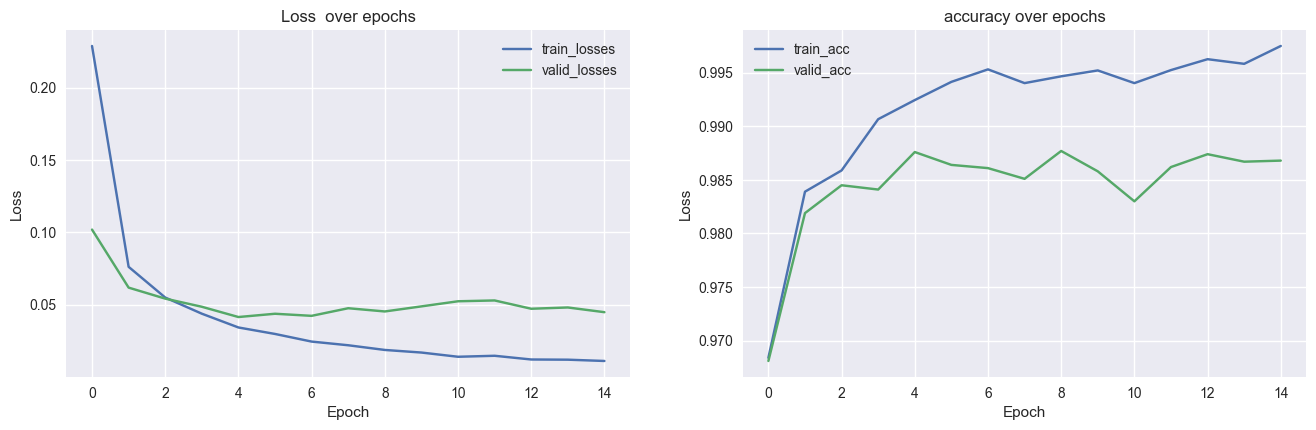

In [31]:
plot_performance(performance_1)

## 1.3.2

In [37]:
torch.manual_seed(RANDOM_SEED)
layers = [1024, 256, 64, 16, N_CLASSES]
model = MLP(layers)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

MLP(
  (all_layers): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [38]:
model, optimizer, performance_2 = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS)

21:53:59 Epoch: 0	Train loss: 0.3575	Valid loss: 0.1636	Train accuracy: 95.61	Valid accuracy: 95.23
21:54:53 Epoch: 1	Train loss: 0.1307	Valid loss: 0.1195	Train accuracy: 97.27	Valid accuracy: 96.38
21:55:42 Epoch: 2	Train loss: 0.0924	Valid loss: 0.1024	Train accuracy: 97.86	Valid accuracy: 96.99
21:56:28 Epoch: 3	Train loss: 0.0722	Valid loss: 0.0876	Train accuracy: 98.29	Valid accuracy: 97.38
21:57:18 Epoch: 4	Train loss: 0.0594	Valid loss: 0.0877	Train accuracy: 98.52	Valid accuracy: 97.36
21:58:05 Epoch: 5	Train loss: 0.0504	Valid loss: 0.0836	Train accuracy: 98.79	Valid accuracy: 97.43
21:58:51 Epoch: 6	Train loss: 0.0438	Valid loss: 0.0819	Train accuracy: 99.06	Valid accuracy: 97.66
21:59:37 Epoch: 7	Train loss: 0.0386	Valid loss: 0.0759	Train accuracy: 99.20	Valid accuracy: 97.75
22:00:23 Epoch: 8	Train loss: 0.0339	Valid loss: 0.0871	Train accuracy: 99.01	Valid accuracy: 97.60
22:01:09 Epoch: 9	Train loss: 0.0299	Valid loss: 0.0802	Train accuracy: 99.23	Valid accuracy: 97.76


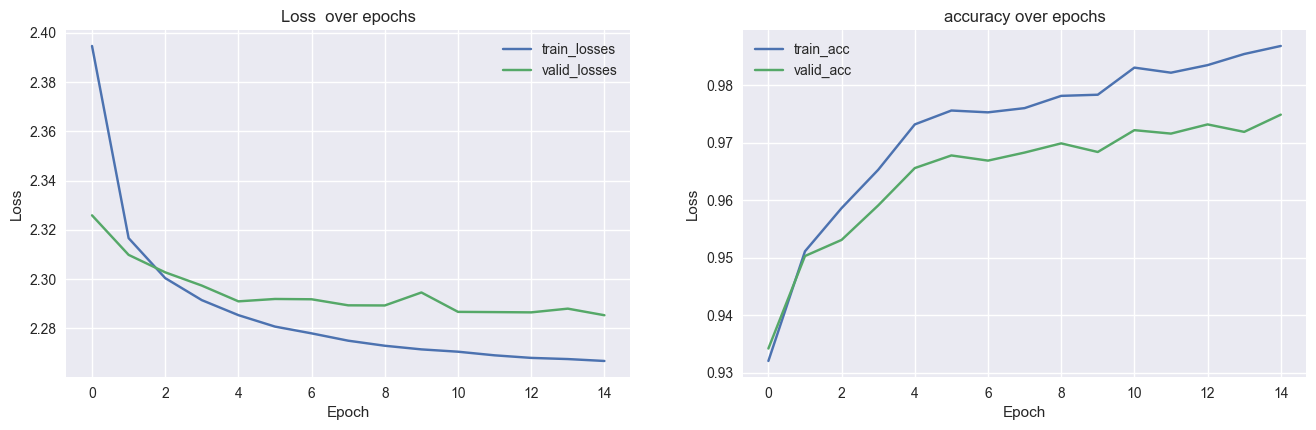

In [ ]:
plot_performance(performance_2)

## 1.4.1 Comparison of these two models.  
Convolutional Layers 1:  
nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)  
(5 * 5 * 1 + 1) * 6 = 156  

Convolutional Layers 2:  
nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)  
(5 * 5 * 6 + 1 ) * 16 = 2416  

Convolutional Layers 3:  
nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)  
(5 * 5 * 16 + 1) * 120 = 48120  

Fully Connected 1:  
nn.Linear(in_features=120, out_features=84)  
(120 + 1) * 84 = 10164  

Fully Connected 2:  
nn.Linear(in_features=84, out_features=10)  
(84 + 1) * 10 = 850  

Total: 156+2416+48120+10164+850=61706


## 1.4.2 number of trainable parameters of MLP  
Fully Connected Layers 1:  
Linear(in_features=1024, out_features=256, bias=True)   
(1024 + 1) * 256 = 262400  

Fully Connected Layers 2:  
Linear(in_features=256, out_features=64, bias=True)  
(256 + 1) * 64 = 16448  

Fully Connected Layers 3:  
Linear(in_features=64, out_features=16, bias=True)  
(64 + 1) * 16 = 1040  

Last Fully Connected Layers:  
Linear(in_features=16, out_features=10, bias=True)  
(16 +1) * 10 = 170  

Total: 262400+16448+1040+170=280058

## 1.4.3  
LeNet is the better than MLP.

LeNet:  
Epoch: 14	Train loss: 0.0111	Valid loss: 0.0449	Train accuracy: 99.75	Valid accuracy: 98.68  
MLP:    
Epoch: 14	Train loss: 0.0242	Valid loss: 0.0874	Train accuracy: 99.31	Valid accuracy: 97.88  
Obviously, the CNN has higher train accuracy and valid accuracy.  

CNNs generally perform better in handling high-dimensional data like images because they can automatically learn features and have better generalization capabilities. MLPs may perform well in some simple tasks or low-dimensional data

# Statement of Collaboration
I do it by myself